In [1]:
import sqlite3
import pandas as pd
import numpy as np
import re
import string
import datetime as dt
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

In [2]:
conn = sqlite3.connect('../redditPosts.sqlite')
cur = conn.cursor()

## Get the list of existing subreddits in the database.

In [3]:
cur.execute('''SELECT subreddit FROM Posts GROUP BY subreddit ORDER BY (COUNT(id))''')
subreddits = list(map(lambda x: x[0], cur.fetchall()))

subreddits

['Superstonks',
 'finance',
 'options',
 'pennystocks',
 'amcstock',
 'GME',
 'CryptoCurrency',
 'dogecoin',
 'wallstreetbets']

In [4]:
for subreddit in subreddits:
    cur.execute('''SELECT AVG(score), COUNT(score), flag FROM
                    (SELECT B.score, (CASE
                                    WHEN B.body == '[deleted]' OR B.body == '[removed]' THEN 0
                                    ELSE 1
                                    END) AS flag
                    FROM PostBodyAndScore B
                    JOIN (SELECT id FROM Posts WHERE subreddit ==?) P
                    On P.id = B.id) comb
                    GROUP BY flag''', (subreddit,))

    print(subreddit,cur.fetchall())

Superstonks [(1.4615384615384615, 26, 0), (12.1, 120, 1)]
finance [(16.512359550561797, 445, 0), (49.87940705128205, 2496, 1)]
options [(5.675890340763515, 7806, 0), (27.118068996925878, 8783, 1)]
pennystocks [(5.620451248495324, 32399, 0), (72.21061123177164, 16115, 1)]
amcstock [(17.93377755244924, 41421, 0), (104.13195268489488, 80059, 1)]
GME [(45.454079474483066, 40189, 0), (137.4685982088646, 105408, 1)]
CryptoCurrency [(3.595744680851064, 282, 0), (67.27064220183486, 218, 1)]
dogecoin [(3.3076923076923075, 26, 0), (49.43283582089552, 67, 1)]
wallstreetbets [(18.386555853530623, 436651, 0), (248.8108802860313, 162220, 1)]


## Retrieve data from the database based on the subreddit.

In [5]:
subreddit = 'GME'
cmd = '''SELECT P.title, P.author, P.ext_link, P.created, B.body, B.score 
            FROM (SELECT * FROM Posts WHERE subreddit = '{}') P 
            JOIN PostBodyAndScore B
            On P.id = B.id
            WHERE B.body != "[removed]" AND B.body != "[deleted]"'''.format(subreddit)

df = pd.read_sql(cmd, conn)

In [6]:
df.head()

,title,author,ext_link,created,body,score
0,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,1609786946,After watching this I took a position RIGHT AW...,6
1,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1609841999,This guy explained exactly how to take a posit...,2
2,ICR conference (11th Jan),nicky94,https://www.reddit.com/r/GME/comments/krnthg/i...,1609939549,Any speculation or ideas on what Gamestop migh...,14
3,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,https://www.reddit.com/r/GME/comments/kuo3w1/g...,1610315957,"After some downwards movement, I think everyb...",11
4,Ryan Cohen appointed to board!!!!?,nicky94,https://news.gamestop.com/news-releases/news-r...,1610368592,,18


## Feature Engineering

In [7]:
df_model = df.copy()

df_model['Popular'] = 1*(df_model['score'] > np.percentile(df_model['score'], 95))

df_model.head()

,title,author,ext_link,created,body,score,Popular
0,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,1609786946,After watching this I took a position RIGHT AW...,6,0
1,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1609841999,This guy explained exactly how to take a posit...,2,0
2,ICR conference (11th Jan),nicky94,https://www.reddit.com/r/GME/comments/krnthg/i...,1609939549,Any speculation or ideas on what Gamestop migh...,14,0
3,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,https://www.reddit.com/r/GME/comments/kuo3w1/g...,1610315957,"After some downwards movement, I think everyb...",11,0
4,Ryan Cohen appointed to board!!!!?,nicky94,https://news.gamestop.com/news-releases/news-r...,1610368592,,18,0


In [8]:
def emoji_count(s):
    s = ''.join(word.strip(string.punctuation) for word in s.split())
    return len(re.findall('[^\w\s,\(\)\'\/-]',s))

def hourOfDay(utc):
    return dt.datetime.utcfromtimestamp(utc).hour

def dayOfWeek(utc):
    return dt.datetime.utcfromtimestamp(utc).weekday()

def textLength(text):
    return len(text.split())

def postType(link):
    if not link:
        return 'others'
    if 'png' in link or 'jpg' in link:
        return 'figures'
    elif '/r/' in link:
        return 'others'
    else:
        return 'outside_link'

def countUpper(text):
    Up = 0
    Low = 0
    for ch in text:
        if ch.isupper():
            Up += 1
        elif ch.islower():
            Low += 1
    
    if Up + Low:
        return Up/(Up+Low)
    else:
        return 0
    
def exclamationAndQuestion(text):
    return text.count('!') + text.count('?')

def getMonth(utc):
    return dt.datetime.utcfromtimestamp(utc).month

def getAuthorInfo(author,created, df):
    df_author = df[df['author'] == author]
    df_prevHist = df_author[df_author['created'] < created]
    
    if df_prevHist.shape[0] == 0:
        return 0, 1, 1
    
    log_post = np.log10(df_prevHist.shape[0])
    mean_upvotes = df_prevHist['score'].mean()
    max_upvotes = df_prevHist['score'].max()
    return log_post, mean_upvotes, max_upvotes
    
def primeTime(hour):
    primeTime = 1 if hour >= 7 and hour <= 11 else 0
    
    return primeTime

def weekend(day):
    return 1 if day >= 5 else 0

def featureProcessing(df_model):
    df_model['title_emoji'] = df_model['title'].apply(emoji_count)
    df_model['body_emoji'] = df_model['body'].apply(emoji_count)
    df_model['title_length'] = df_model['title'].apply(textLength)
    df_model['body_length'] = df_model['body'].apply(textLength)
    df_model['title_EQ'] = df_model['title'].apply(exclamationAndQuestion)
    df_model['body_EQ'] = df_model['body'].apply(exclamationAndQuestion)
    df_model['title_UL'] = df_model['title'].apply(countUpper)
    df_model['body_UL'] = df_model['body'].apply(countUpper)    
    df_model['hour'] = df_model['created'].apply(hourOfDay)
    df_model['day'] = df_model['created'].apply(dayOfWeek)
    df_model['post_type'] = df_model['ext_link'].apply(postType)
    df_model['prime_time'] = df_model['hour'].apply(primeTime)
    df_model['weekend'] = df_model['day'].apply(weekend)
    df_model['month'] = df_model['created'].apply(getMonth)
    
    
    for row in range(df_model.shape[0]):
        df_model.loc[row, ['log_num', 'mean_upvotes', 'max_upvotes']] = getAuthorInfo(df_model.loc[row,'author'], df_model.loc[row,'created'], df_model)

    

In [9]:
featureProcessing(df_model)

In [31]:
df_twitter = pd.read_csv('../Twitter Data/TWEETS+SENTIMENT_individual.csv')

df_twitter.Date = df_twitter.Date.astype('str')

def convertToUNIX(date):
    try:
        result = np.datetime64(date).astype('datetime64[s]').astype('int')
    except:
        result = 0
    return result

df_twitter['Vader_weighted'] = df_twitter['Vader'] * df_twitter['retweet']

df_grouped = df_twitter.groupby('Date').sum()

df_grouped['Date'] = df_grouped.index

df_grouped['UNIX'] = df_grouped.Date.apply(convertToUNIX)

def getTwitterInfo(timestamp, df, gap = 86400*3):
    df_sum = df[(df['UNIX'] < timestamp) & (df['UNIX'] >= timestamp - gap)].sum()
    
    return df_sum.retweet, df_sum.likes, df_sum.num, df_sum.Vader_weighted/df_sum.retweet


for i in range(df_model.shape[0]):
    df_model.loc[i,['retweet', 'likes', 'num', 'twitter_sent']] = getTwitterInfo(df_model.loc[i,'created'], df_grouped)

C:\Users\kungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
analyzer = SentimentIntensityAnalyzer()

def sentiment(title):
    
    return analyzer.polarity_scores(title)['compound']

df_model['sentiment'] = df_model['title'].apply(sentiment)

In [11]:
df_model[['figures', 'outside_link']] = pd.get_dummies(df_model['post_type'])[['figures', 'outside_link']]
df_model['title_EQ_Norm'] = df_model['title_EQ']/df_model['title_length']

In [22]:
df_model.twitter_sent.max()

0.2793348148148148

## Some exploratory data analysis on the features

### Effect of time and day

In [12]:
hots = np.zeros((7,24))

for hr in range(24):
    df_hour = df_model[df_model['hour'] == hr]
    for dy in range(7):
        hots[dy,hr] = df_hour[df_hour['day'] == dy].Popular.mean()

0.1569767441860465


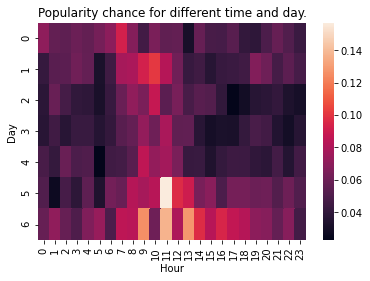

In [13]:
import seaborn as sns

ax = sns.heatmap(hots)
ax.set_title('Popularity chance for different time and day.')
ax.set_xlabel('Hour')
ax.set_ylabel('Day')
print(np.max(hots))

### Effect of Uppercase Proportion of the post

Text(0.5, 1.0, 'The proportion of uppercase letters in titles/bodies vs popular rate.')

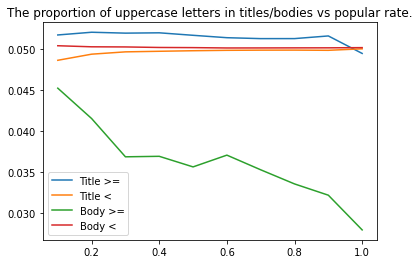

In [89]:
xx = np.linspace(0.1,1,10)

titlesL = []
titlesS = []
bodiesL = []
bodiesS = []

for x in xx:
    titlesL.append(df_model[df_model['title_UL'] >= x].Popular.mean())
    titlesS.append(df_model[df_model['title_UL'] < x].Popular.mean())
    bodiesL.append(df_model[df_model['body_UL'] >= x].Popular.mean())
    bodiesS.append(df_model[df_model['body_UL'] < x].Popular.mean())

    
plt.plot(xx,titlesL, label = 'Title >=')
plt.plot(xx,titlesS, label = 'Title <')
plt.plot(xx,bodiesL, label = 'Body >=')
plt.plot(xx,bodiesS, label = 'Body <')

plt.legend()
plt.title('The proportion of uppercase letters in titles/bodies vs popular rate.')

### Effect of Exclamation Points and Question Marks

Text(0.5, 1.0, 'The proportion of exclamation points/question marks in titles/bodies vs popular rate.')

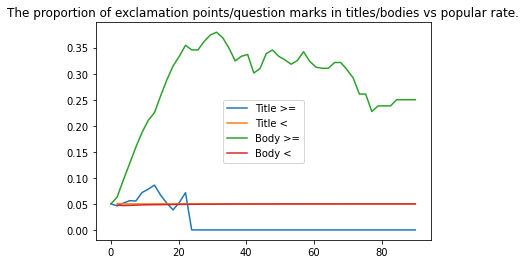

In [88]:
xx = np.linspace(0,90)

titlesL = []
titlesS = []
bodiesL = []
bodiesS = []

for x in xx:
    titlesL.append(df_model[df_model['title_EQ'] >= x].Popular.mean())
    titlesS.append(df_model[df_model['title_EQ'] < x].Popular.mean())
    bodiesL.append(df_model[df_model['body_EQ'] >= x].Popular.mean())
    bodiesS.append(df_model[df_model['body_EQ'] < x].Popular.mean())

    
plt.plot(xx,titlesL, label = 'Title >=')
plt.plot(xx,titlesS, label = 'Title <')
plt.plot(xx,bodiesL, label = 'Body >=')
plt.plot(xx,bodiesS, label = 'Body <')

plt.legend()
plt.title('The proportion of exclamation points/question marks in titles/bodies vs popular rate.')

Text(0.5, 1.0, 'The proportion of exclamation points/question marks in titles vs popular rate.')

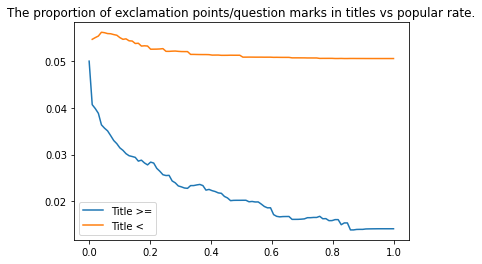

In [74]:
xx = np.linspace(0,1, 100)


titlesLN = []
titlesSN = []


for x in xx:
    titlesLN.append(df_model[df_model['title_EQ_Norm'] >= x].Popular.mean())
    titlesSN.append(df_model[df_model['title_EQ_Norm'] < x].Popular.mean())


    
plt.plot(xx,titlesLN, label = 'Title >=')
plt.plot(xx,titlesSN, label = 'Title <')


plt.legend()
plt.title('The proportion of exclamation points/question marks in titles vs popular rate.')

### Check the feasibility of splitting the training/testing set by time

In [95]:

df_model_TrAiN = df_model[df_model['month'] < 5]
df_model_TeSt = df_model[df_model['month'] >= 5]

df_model_TeSt.head()

print(df_model_TrAiN.Popular.count())

print(df_model_TeSt.Popular.count())

99960
5448


## Training the Model

Since the dataset is quite imbalanced (~3% popular posts), I decided to use oversampling to make a balanced dataset. One thing I realized is that I should not oversample before splitting the dataset into training/testing sets, as the testing datapoints will have leaked into the training set. 

By extension, the cross validation also shouldn't be performed if we oversample. I did not think of that when writing this block, so you can see that the cross validation gives increasingly good results as the complexity increases. 

In [117]:
df_features = df_model.drop(columns = ['title','author','ext_link','created','body','post_type','title_EQ','score','max_upvotes'])

X = df_features.drop(columns = ['Popular'])
y = df_model['Popular']

cutoff = 4

X_train, X_test, y_train, y_test = X[X['month'] < cutoff].drop(columns = ['month']), X[X['month'] >= cutoff].drop(columns = ['month']), y[X['month'] < cutoff], y[X['month'] >= cutoff]
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, stratify = y)
X_test.head()

,title_emoji,body_emoji,title_length,body_length,body_EQ,title_UL,body_UL,hour,day,prime_time,weekend,log_num,mean_upvotes,sentiment,figures,outside_link,title_EQ_Norm
76718,0,0,4,69,0,0.166667,0.041237,0,3,0,0,0.000000,1.000000,0.0000,0,0,0.000000
76719,1,0,18,0,0,0.048780,0.000000,0,3,0,0,0.000000,1.000000,0.6351,1,0,0.111111
76720,0,9,3,65,0,0.090909,0.017483,0,3,0,0,0.301030,10.000000,0.0000,0,0,0.000000
76721,0,0,12,0,0,0.317073,0.000000,0,3,0,0,0.477121,10.000000,0.0000,1,0,0.000000
76722,0,3,3,23,1,0.090909,0.102804,0,3,0,0,1.819544,20.848485,0.0000,0,0,0.000000


### Modulizing the training process.

I will write a function to automate the training process, including cross validation.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import clone

### Probability Calibration

Most models are not calibrated in probability, and I would like to see if calibrating the probability can help with the PR curve.


In [107]:
def trainingImbalanced(gridModel, X_train, y_train, weight_factor):
    
    weights = np.ones(y_train.shape)
    
    weights[y_train == 1] = weight_factor/np.mean(y_train)
    gridModel.fit(X_train, y_train, sample_weight = weights)
    
    
    
def trainAndNotCalibrate(gridModel, X_train, y_train, X_test, weight_factor):
    scaler = StandardScaler()
    
    X_transformed = scaler.fit_transform(X_train)
    
    
    trainingImbalanced(gridModel, X_train, y_train, weight_factor)
    
    
    X_testTrans = scaler.transform(X_test)
    
    return gridModel.predict_proba(X_testTrans)[:,1], gridModel.predict_proba(X_transformed)[:,-1], y_train

def trainAndCalibrate1(Model, X_train, y_train, X_test, weight_factor):
    scaler = StandardScaler()
    
    X_transformed = scaler.fit_transform(X_train)

    
    calibrated = CalibratedClassifierCV(Model, method = 'isotonic', cv = 10) #cv = TimeSeriesSplit(n_splits = 8).split(X_train))
    
    calibrated.fit(X_transformed, y_train)
    
    X_testTrans = scaler.transform(X_test)
    
    #return gridModel.predict(X_testTrans), gridModel.predict_proba(X_testTrans)[:,1]
    return calibrated.predict_proba(X_testTrans)[:,1], calibrated.predict_proba(X_transformed)[:,1], y_train, calibrated

def trainAndCalibrate(gridModel, X_train, y_train, X_test, weight_factor):
    scaler = StandardScaler()
    
    X_transformed = scaler.fit_transform(X_train)
    
    X_train_train, X_val, y_train_train, y_val = train_test_split(X_transformed, y_train, test_size = 0.1, stratify = y_train)
    
    trainingImbalanced(gridModel, X_train_train, y_train_train, weight_factor)
    
    calibrated = CalibratedClassifierCV(gridModel, method = 'isotonic', cv = 'prefit')
    
    calibrated.fit(X_val, y_val)
    
    X_testTrans = scaler.transform(X_test)
    
    #return gridModel.predict(X_testTrans), gridModel.predict_proba(X_testTrans)[:,1]
    return calibrated.predict_proba(X_testTrans)[:,1], calibrated.predict_proba(X_val)[:,1], y_val

def trainAndCompareCalibration(Model, X_train, y_train, X_test, y_test, modelName, weight_factor = 1):
    
    yProbCal, yCalTrain, y_valCal, calibrated = trainAndCalibrate1(Model, X_train, y_train, X_test, weight_factor)

    

    precCal, recCal, thresholdCal = precision_recall_curve(y_test, yProbCal)
    plt.plot(recCal,precCal, label = f'Calibrated {modelName}')
 
    
    trainInfo = precision_recall_curve(y_valCal, yCalTrain)
    plt.plot(trainInfo[1],trainInfo[0], label = f'Calibrated Train {modelName}')  
    
    plt.grid()
    plt.legend()
    plt.show()
    
    return calibrated, trainInfo
    #return thresholdCal


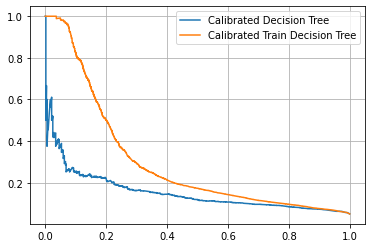

(CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(max_depth=8),
                        cv=10, method='isotonic'),
 (array([0.04996469, 0.05554834, 0.05611885, ..., 1.        , 1.        ,
         1.        ]),
  array([1.        , 0.992827  , 0.99135021, ..., 0.00632911, 0.00611814,
         0.        ]),
  array([0.01088504, 0.01151126, 0.01163482, ..., 0.43614442, 0.44557354,
         0.44728477])))

In [112]:
tree_clf = DecisionTreeClassifier(max_depth = 8)

trainAndCompareCalibration(tree_clf, X_train, y_train, X_test, y_test,'Decision Tree', 1)

In [18]:
tree_clf.best_estimator_

DecisionTreeClassifier(max_depth=6)

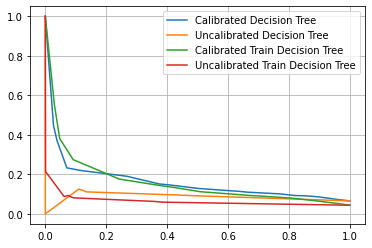

array([0.00846154, 0.01399027, 0.02061856, 0.02139037, 0.02658789,
       0.04464286, 0.05405405, 0.06129398, 0.06277056, 0.0862069 ,
       0.10722611, 0.12449799, 0.19417476, 0.21126761, 0.25      ,
       0.55555556])

In [37]:
tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid = {'max_depth': range(4,7)}, scoring = 'precision')

trainAndCompareCalibration(tree_clf, X_train, y_train, X_test, y_test,'Decision Tree', 1)

In [31]:
Name = []
Importance = []
for name, importance in zip(X_train.columns, cal_rf.feature_importances_):
    Name.append(name)
    Importance.append(importance)

df_imp = pd.DataFrame({'Name': Name, 'Importance': Importance})

df_imp.sort_values('Importance', ascending = False)

AttributeError: 'CalibratedClassifierCV' object has no attribute 'feature_importances_'

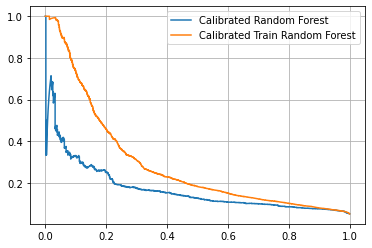

In [101]:
rf_clf = RandomForestClassifier(max_depth = 8)
cal_rf, rf_info = trainAndCompareCalibration(rf_clf, X_train, y_train, X_test, y_test, 'Random Forest', 1)

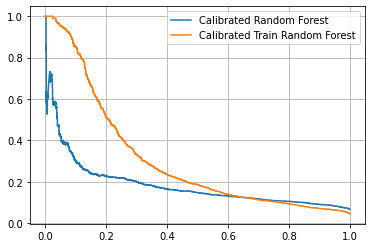

In [92]:
rf_clf = RandomForestClassifier(max_depth = 8, n_estimators = 200)
cal_rf, rf_info = trainAndCompareCalibration(rf_clf, X_train, y_train, X_test, y_test, 'Random Forest', 1)

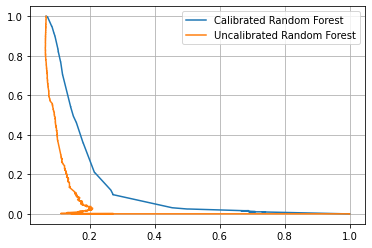

array([0.        , 0.00228124, 0.00357458, 0.00469006, 0.00564972,
       0.00760067, 0.00804717, 0.00842891, 0.00954806, 0.01043111,
       0.01339122, 0.01754386, 0.01758369, 0.01788909, 0.01811566,
       0.01958579, 0.02297214, 0.02545455, 0.02610213, 0.02679308,
       0.02681992, 0.03347068, 0.03571429, 0.03574445, 0.03580395,
       0.03581836, 0.03587661, 0.03588061, 0.03591471, 0.03591774,
       0.03594538, 0.03597405, 0.0359933 , 0.03603748, 0.03605057,
       0.03609272, 0.0361128 , 0.03611333, 0.03611505, 0.03617021,
       0.03849806, 0.03981481, 0.04243211, 0.043131  , 0.04347826,
       0.04352651, 0.04654953, 0.05057471, 0.05068569, 0.05082598,
       0.05085229, 0.05093842, 0.0511453 , 0.05152934, 0.0519478 ,
       0.05302956, 0.05368517, 0.05436251, 0.056674  , 0.05834039,
       0.06067712, 0.06080966, 0.06540934, 0.06576784, 0.06756757,
       0.06896552, 0.07815235, 0.08646328, 0.08701083, 0.0952381 ,
       0.10069469, 0.10229654, 0.10255393, 0.10572703, 0.10738

In [80]:
rf_clf = GridSearchCV(RandomForestClassifier(), param_grid = {'max_depth': range(5,9)}, scoring = 'f1')
trainAndCompareCalibration(rf_clf, X_train, y_train, X_test, y_test, 'Random Forest', 1)

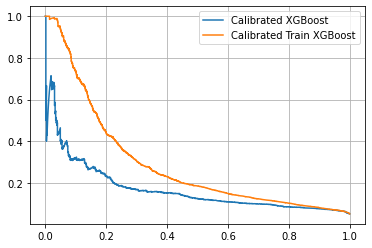

In [102]:
xgb = XGBClassifier(verbosity=0)

cal_xgb, xgb_info = trainAndCompareCalibration(rf_clf, X_train, y_train, X_test, y_test, 'XGBoost', 1)

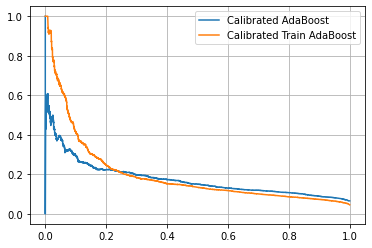

CalibratedClassifierCV(base_estimator=AdaBoostClassifier(n_estimators=500),
                       cv=10, method='isotonic')

In [39]:
ada_clf = AdaBoostClassifier(n_estimators= 500)

trainAndCompareCalibration(ada_clf, X_train, y_train, X_test, y_test, 'AdaBoost')

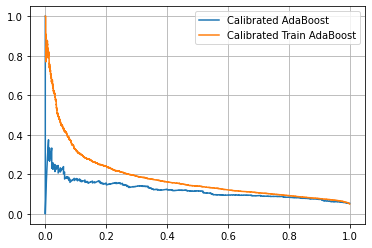

In [97]:
ada_clf = AdaBoostClassifier(n_estimators= 100)

cal_ada, ada_info = trainAndCompareCalibration(ada_clf, X_train, y_train, X_test, y_test, 'AdaBoost')

C:\Users\kungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

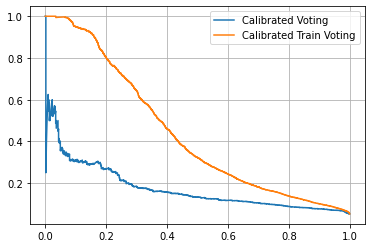

(CalibratedClassifierCV(base_estimator=VotingClassifier(estimators=[('rf',
                                                                     RandomForestClassifier(max_depth=8)),
                                                                    ('xgb',
                                                                     XGBClassifier(base_score=None,
                                                                                   booster=None,
                                                                                   colsample_bylevel=None,
                                                                                   colsample_bynode=None,
                                                                                   colsample_bytree=None,
                                                                                   gamma=None,
                                                                                   gpu_id=None,
                                   

In [113]:
vote_clf = VotingClassifier([('rf',RandomForestClassifier(max_depth = 8)), 
                             ('xgb', XGBClassifier(verbosity=0)),
                            ('tree', DecisionTreeClassifier(max_depth = 8))],
                               voting = 'soft')

trainAndCompareCalibration(vote_clf, X_train, y_train, X_test, y_test, 'Voting')

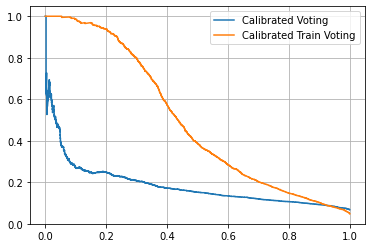

(CalibratedClassifierCV(base_estimator=VotingClassifier(estimators=[('rf',
                                                                     RandomForestClassifier(max_depth=8)),
                                                                    ('xgb',
                                                                     XGBClassifier(base_score=None,
                                                                                   booster=None,
                                                                                   colsample_bylevel=None,
                                                                                   colsample_bynode=None,
                                                                                   colsample_bytree=None,
                                                                                   gamma=None,
                                                                                   gpu_id=None,
                                   

In [118]:
vote_clf = VotingClassifier([('rf',RandomForestClassifier(max_depth = 8)), 
                             ('xgb', XGBClassifier(verbosity=0)),
                            ('tree', DecisionTreeClassifier(max_depth = 8))],n_jobs = 4,
                               voting = 'soft')

trainAndCompareCalibration(vote_clf, X_train, y_train, X_test, y_test, 'Voting')

### Maximum Voting

We tried the voting classifier before, but the result was not great. We will try to see if we can do things differently.

[[8685 1329]
 [ 419  108]]
[[5111 4903]
 [ 275  252]]
[[8374 1640]
 [ 401  126]]
[[5235 4779]
 [ 281  246]]


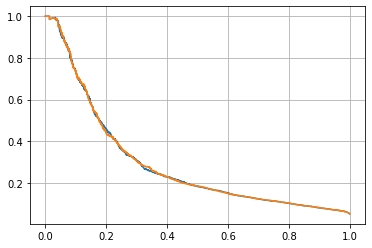

In [105]:
def maxVoting(models, thresholds, X_test, y_test):
    predictions = []
    
    for model,threshold in zip(models,thresholds):
        yProba = model.predict_proba(X_test)[:,1]
        print(confusion_matrix(y_test, 1 * (yProba > 0.7)))
        print(confusion_matrix(y_test, 1 * (yProba > 0.4)))
    
    #yPred = np.max(np.hstack(predictions), axis = 1)
    
    #return confusion_matrix(y_test, yPred)

models = [cal_rf, cal_xgb]
infos = [rf_info, xgb_info]
thresholds = []

for info in infos:
    for prec, thres in zip(info[0], info[2]):
        if prec > 0.9:
            thresholds.append(thres)
            break
    
    plt.plot(info[1],info[0])

plt.grid()

#thresholds
maxVoting(models, thresholds, X_test, y_test)


In [60]:
infos[0]

(array([0.04449924, 0.04457421, 0.04457597, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99703704e-01, 9.99703704e-01, ...,
        1.18518519e-03, 2.96296296e-04, 0.00000000e+00]),
 array([0.00256267, 0.00257059, 0.0025732 , ..., 0.90398848, 0.91477273,
        0.92748449]))

In [93]:
import pickle
filename = './saved_models/KC_0525_rf.sav'
pickle.dump(cal_rf, open(filename,'wb'))

In [94]:
scaler = StandardScaler().fit(X_train)
filename = './saved_models/KC_0525_scaler.sav'
pickle.dump(scaler, open(filename,'wb'))


### Use the important features to train again

In [33]:
df_features[df_imp.sort_values('Importance', ascending = False).Name.values[:15]].head()

,title_length,mean_upvotes,body_length,body_emoji,figures,body_EQ,title_UL,body_UL,log_num,title_emoji,title_EQ,day_3,day_6,day_4,outside_link
0,8,1.0,11,3,0,0,0.333333,0.278689,0.00000,6,0,0,0,0,0
1,10,6.0,17,11,0,2,1.000000,0.105691,0.00000,1,0,0,0,0,0
2,4,1.0,86,1,0,2,0.222222,0.048387,0.00000,0,0,0,0,0,0
3,14,4.0,43,5,0,1,0.166667,0.040724,0.30103,3,0,0,1,0,0
4,5,14.0,0,0,0,0,0.080000,0.000000,0.00000,0,5,0,0,0,1


In [34]:
impColumns = df_imp.sort_values('Importance', ascending = False).Name.values[:15]

X = df_features[impColumns]
y = df_model['Popular']

X_train, X_test, y_train, y_test = X[df_model['month'] < 4], X[df_model['month'] >= 4], y[df_model['month'] < 4], y[df_model['month'] >= 4]



[[17306 10223]
 [  350   811]]
DecisionTreeClassifier(max_depth=5)


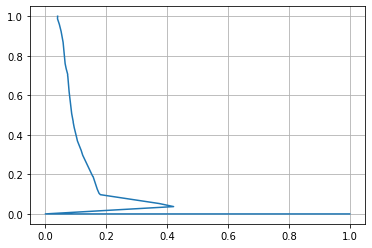

(array([0.04046706, 0.04013308, 0.04623053, 0.05195561, 0.0585094 ,
        0.06515643, 0.0685967 , 0.0735426 , 0.07350009, 0.07397912,
        0.07831786, 0.0867069 , 0.09178826, 0.09168371, 0.09499719,
        0.10295804, 0.1055091 , 0.1143445 , 0.11792602, 0.12286325,
        0.15574348, 0.15691869, 0.17078916, 0.17664234, 0.18108974,
        0.37423313, 0.42156863, 0.        , 1.        ]),
 array([1.        , 0.9870801 , 0.95865633, 0.92334195, 0.86821705,
        0.76055125, 0.73471146, 0.70628768, 0.69853575, 0.69595177,
        0.61757106, 0.50732127, 0.46597761, 0.46339363, 0.43669251,
        0.38673557, 0.36950904, 0.33505599, 0.32127476, 0.29715762,
        0.19035314, 0.18949182, 0.12489233, 0.1042205 , 0.09732989,
        0.05254091, 0.03703704, 0.        , 0.        ]),
 array([0.        , 0.08324463, 0.22763541, 0.35170271, 0.42229311,
        0.42667957, 0.47753755, 0.48899104, 0.52769799, 0.54166478,
        0.57820423, 0.58671193, 0.59405312, 0.60689033, 0.68385087,


In [35]:
tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid = {'max_depth': range(4,7)}, scoring = 'precision')

trainAndShowConfusionMatrix(tree_clf, X_train, y_train, X_test, y_test,1)
